# 03_experimentation.ipynb

## Imports & Settings

In [19]:
import os
import polars as pl
import numpy as np
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


sns.set_theme(style="whitegrid")

mlflow.set_tracking_uri("file:../mlruns")
# Set MLflow experiment name
mlflow.set_experiment("Favorita_Model_Selection_Notebook")

print("Libraries loaded & Experiment set!")

Libraries loaded & Experiment set!


## Load Data

In [20]:
df = pl.read_parquet("../data/processed/train_features.parquet")

print(f"Total rows: {df.height}")
display(df.head(3))

df = df.drop_nulls(subset=["sales"])

# Split Train / Validation
# Let last 16 days data be validation set
split_date = pl.date(2017, 8, 1)

train = df.filter(pl.col("date") < split_date)
val = df.filter(pl.col("date") >= split_date)

print(f"Train Size: {train.height}")
print(f"Val size: {val.height}")

Total rows: 2929872


id,date,store_nbr,family,sales,onpromotion,oil_price,city,state,type,cluster,split,month,day_of_week,day_of_month,is_payday,is_holiday,is_earthquake,lag_16,lag_30,lag_60,rolling_mean_30,rolling_mean_60
i64,date,i64,str,f64,i64,f64,str,str,str,i64,str,i8,i8,i8,i8,i8,i8,f64,f64,f64,f64,f64
106920,2013-03-02,1,"""AUTOMOTIVE""",1.0,0,null,"""Quito""","""Pichincha""","""D""",13,"""train""",3,6,2,0,0,0,0.0,0.0,0.0,1.8,null
108702,2013-03-03,1,"""AUTOMOTIVE""",2.0,0,null,"""Quito""","""Pichincha""","""D""",13,"""train""",3,7,3,0,0,0,0.0,3.0,2.0,1.766667,null
110484,2013-03-04,1,"""AUTOMOTIVE""",5.0,0,90.13,"""Quito""","""Pichincha""","""D""",13,"""train""",3,1,4,0,0,0,1.0,0.0,3.0,1.766667,null


Train Size: 2874630
Val size: 26730


## Define evaluation functions & features

In [21]:
def evaluate_rmsle(y_true, y_pred):
    # Make sure the prediction is non-negative
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

FEATURES = [
    "onpromotion", "lag_16", "lag_30",
    "rolling_mean_30", "rolling_mean_60"
]

TARGET = "sales"

X_train = train.select(FEATURES).to_pandas()
y_train = train[TARGET].to_numpy()
X_val = val.select(FEATURES).to_pandas()
y_val = val[TARGET].to_numpy()

## Exp. 1 - Baseline (Naive Approach)

In [22]:
with mlflow.start_run(run_name="Baseline_Naive"):
    # Naive Rule: Predict future sales = sales 16 days ago
    y_pred_naive = val["lag_16"].to_numpy()
    
    y_pred_naive = np.nan_to_num(y_pred_naive, nan=0)
    
    rmsle_naive = evaluate_rmsle(y_val, y_pred_naive)
    print(f"Baseline RMSLE: {rmsle_naive:.4f}")
    
    mlflow.log_metric("rmsle", rmsle_naive)
    mlflow.log_param("model_type", "Naive Rule")

Baseline RMSLE: 0.6980


## Exp. 2 - Linear Model (Ridge)

In [23]:
with mlflow.start_run(run_name="Linear_Ridge"):
    # preprocessing
    numeric_features = [f for f in FEATURES]
    
    preprocessor = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])
    
    # Define Model (Ridge)
    model_linear = Pipeline([
        ('preprocessor', ColumnTransformer(
            transformers=[('num', preprocessor, numeric_features)]
        )),
        ('regressor', Ridge(alpha=1.0))
    ])
    
    # Train
    print("Training Linear Model...")
    model_linear.fit(X_train, y_train)
    
    # Prediction
    y_pred_linear = model_linear.predict(X_val)
    rmsle_linear = evaluate_rmsle(y_val, y_pred_linear)
    print(f"Linear RMSLE: {rmsle_linear:.4f}")
    
    mlflow.log_metric("rmsle", rmsle_linear)
    mlflow.sklearn.log_model(model_linear, "model")

Training Linear Model...


2026/01/30 00:57:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Linear RMSLE: 0.8857


## Exp.3 - XGBoost

In [24]:
with mlflow.start_run(run_name="XGBoost_V1"):
    print("Training XGBoost...")
    
    model_xgb = xgb.XGBRegressor(
        objective='reg:squaredlogerror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        n_jobs=-1
    )
    
    model_xgb.fit(X_train, y_train)
    
    y_pred_xgb = model_xgb.predict(X_val)
    rmsle_xgb = evaluate_rmsle(y_val, y_pred_xgb)
    print(f"XGBoost RMSLE: {rmsle_xgb:.4f}")
    
    mlflow.log_metric("rmsle", rmsle_xgb)
    mlflow.sklearn.log_model(model_xgb, "model")

Training XGBoost...


2026/01/30 00:57:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


XGBoost RMSLE: 0.6145


## Visualization

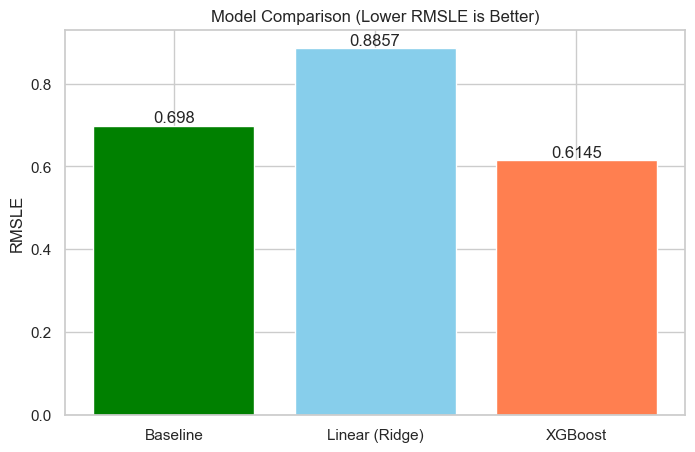

<Figure size 1000x600 with 0 Axes>

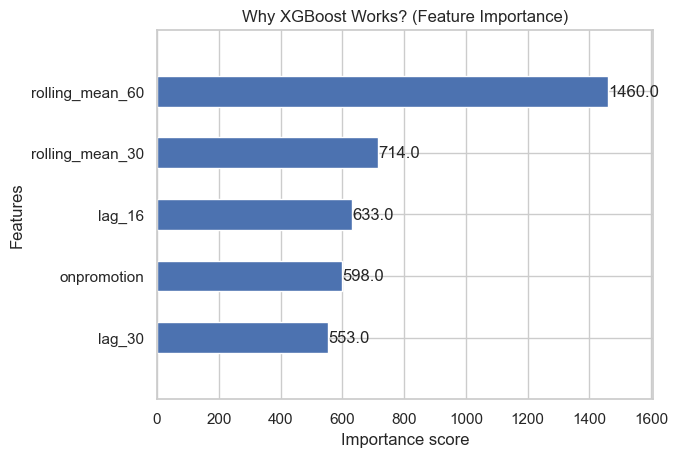

In [25]:
# comparison metrics
models = ['Baseline', 'Linear (Ridge)', 'XGBoost']
scores = [rmsle_naive, rmsle_linear, rmsle_xgb]

plt.figure(figsize=(8, 5))
bars = plt.bar(models, scores, color=['green', 'skyblue', 'coral'])
plt.title('Model Comparison (Lower RMSLE is Better)')
plt.ylabel('RMSLE')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')
    
plt.show()

# compare Feature Importance (XGBoost)
plt.figure(figsize=(10, 6))
xgb.plot_importance(model_xgb, max_num_features=10, importance_type='weight', height=0.5)
plt.title('Why XGBoost Works? (Feature Importance)')
plt.show()
